In [267]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# SKLEARN
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [268]:
## CHARTS

def plot_sales(dataframe, title, ylabel, xlabel, color='red'):
    
    plt.figure(figsize=(15, 3))
    plt.title(title)
    plt.ylabel(ylabel, color='white')
    # format y axis as currency
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.xlabel(xlabel, color='white')

    plt.bar(dataframe.index, dataframe['Total Sales'])
    # plot mean price in 2nd y axis
    plt.twinx()
    plt.ylabel('Mean Price', color='white')
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.plot(dataframe.index, dataframe['Mean Price'], color=color, linewidth=4)
    plt.show()

In [269]:
## MODELS

def fit_models(X_train, y_train, X_test, y_test):
    models = {'Linear Regression': LinearRegression(),
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest': RandomForestRegressor(),
              'Gradient Boosting': GradientBoostingRegressor()}

    models_df = pd.DataFrame(columns=['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
                             index=['R2', 'RMSE', 'MAE'])

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        r2 = r2_score(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        
        models_df[name] = [r2, rmse, mae]

    return models_df, models # returns df with models performance and models dict

In [270]:
## OPEN FILE

lots = pd.read_csv('../clean-files/catalogo_artworks_info.csv', index_col=0)

## JOGAR PARA PREPROCESSING !!!!!
lots['Area (cm²)'] = lots['Height (cm)'] * lots['Width (cm)']

print('Lots count:', lots.shape[0])

Lots count: 7934


In [271]:
# SOLD LOTS
sold_lots = lots[lots['Sold'] == True]
print('Sold lots: ', len(sold_lots))

Sold lots:  3527


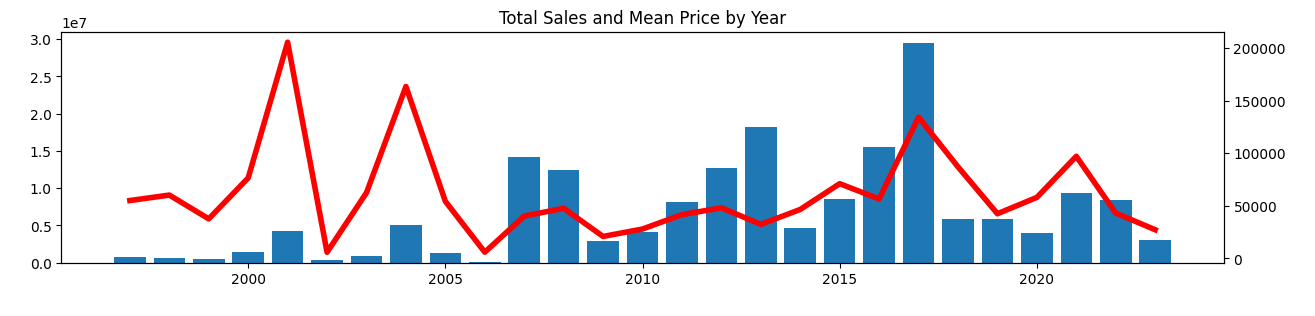

In [272]:
# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
sales = pd.DataFrame(sold_lots.groupby('Year of sale')['Price (BRL)'].sum())
sales['Total Sales'] = sold_lots.groupby('Year of sale')['Price (BRL)'].sum()
sales['Mean Price'] = sold_lots.groupby('Year of sale')['Price (BRL)'].mean()

plot_sales(sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [273]:
# TOP ARTISTS BY SALES COUNT

# dataframe with 2 columns: #sales, total sales ($) and mean price ($)
top_artists = pd.DataFrame(sold_lots['Artist'].value_counts())
top_artists['Total Sales'] = sold_lots.groupby('Artist')['Price (BRL)'].sum()
top_artists['Mean Price'] = sold_lots.groupby('Artist')['Price (BRL)'].mean()
# include mean area
top_artists['Mean Area'] = sold_lots.groupby('Artist')['Area (cm²)'].mean()
# mean price per area
top_artists['Mean Price per Area'] = top_artists['Mean Price'] / top_artists['Mean Area']

top_artists = top_artists.sort_values(by='Total Sales', ascending=False)
top_artists.drop('Mean Area', axis=1, inplace=True)
top_artists.head()

,count,Total Sales,Mean Price,Mean Price per Area
Artist,,,,
Candido Portinari (1903-1962),441,37784107.0,85678.247166,73.084042
José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti,186,25908220.0,139291.505376,100.371192
Alberto Guignard - Alberto da Veiga Guignard,165,23737645.0,143864.515152,53.699549
Di Cavalcanti (1897-1976),320,18733415.0,58541.921875,21.741041
Antônio Bandeira (1922-1967),266,17142535.0,64445.620301,44.426224


In [274]:
## ARTISTS DATAFRAMES

artists = sold_lots.groupby('Artist').apply(lambda x: x.sort_values('Price (BRL)', ascending=False)).reset_index(drop=True).groupby('Artist')

artists_dataframes = {}
for artist in artists:
    artist_name = artist[0]
    artist_df = artist[1]
    artists_dataframes[artist_name] = artist_df

Found 441 lots for Candido Portinari (1903-1962)


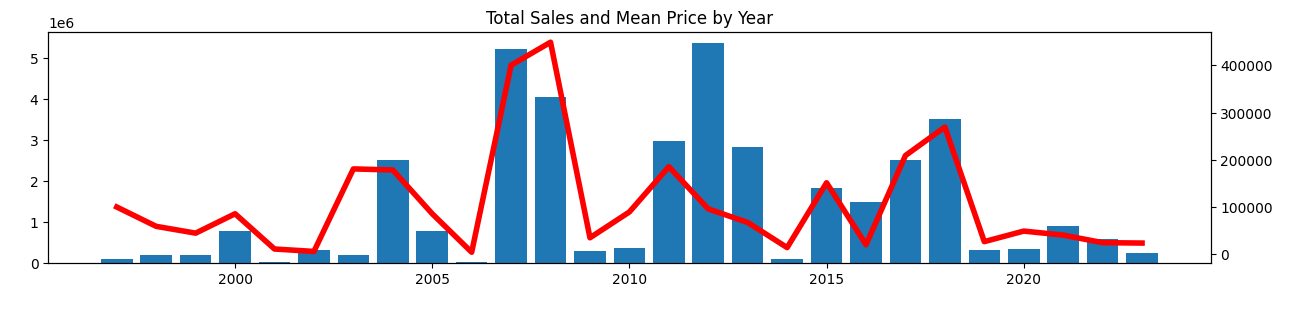

In [275]:
artist_name = 'Candido Portinari (1903-1962)'
artist_df = artists_dataframes[artist_name]

# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
artist_sales = pd.DataFrame(artist_df.groupby('Year of sale')['Price (BRL)'].sum())
artist_sales['Total Sales'] = artist_df.groupby('Year of sale')['Price (BRL)'].sum()
artist_sales['Mean Price'] = artist_df.groupby('Year of sale')['Price (BRL)'].mean()

print(f'Found {artist_df.shape[0]} lots for {artist_name}')
plot_sales(artist_sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [276]:
lots = lots[lots['Medium_type'] != 'outro']

In [277]:
## FIT PRICE MODELS

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

lots_to_model = lots[['Artist', 'Width (cm)', 'Height (cm)', 'Year of sale', 'Price (BRL)', 'Medium_type']].dropna()

print(lots_to_model.shape)

X = lots_to_model.drop(['Price (BRL)'], axis=1)
y = lots_to_model['Price (BRL)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = pd.get_dummies(X_train, columns=['Artist', 'Medium_type'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Artist', 'Medium_type'], drop_first=True)

# add to X_test all columns that are in X_train but not in X_test
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0

# remove from x_test all columns that are in X_test but not in X_train
for column in X_test.columns:
    if column not in X_train.columns:
        X_test.drop(column, axis=1, inplace=True)

# sort columns alphabetically
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

models_df, models = fit_models(X_train, y_train, X_test, y_test)

models_df

(7368, 6)


,Linear Regression,Decision Tree,Random Forest,Gradient Boosting
R2,0.309512,0.916979,0.927182,0.918050
RMSE,500014.843937,173379.903117,162376.672159,172257.915655
MAE,250213.293327,33597.725755,30054.203122,59192.297843


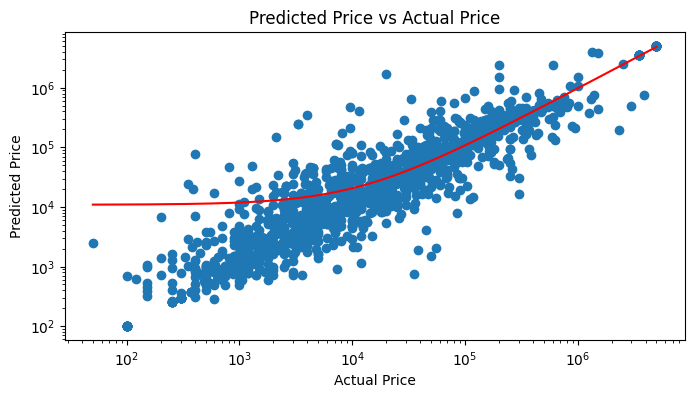

In [292]:
## COMPARE MODEL PERFORMANCE ACROSS MEDIUM TYPES
# add predicted_price column to lots_to_model
lots_copy = X_test.copy()
lots_copy['Predicted Price'] = models['Random Forest'].predict(X_test)
lots_copy['Actual Price'] = y_test
lots_copy['Error'] = lots_copy['Predicted Price'] - lots_copy['Actual Price']
lots_copy['Error %'] = lots_copy['Error'] / lots_copy['Actual Price'] - 1

# scatter plot: predicted price vs actual price
plt.figure(figsize=(8,4))
plt.title('Predicted Price vs Actual Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
# format axes: separate thousands with comma and format as currency
plt.gca().xaxis.set_major_formatter('${x:,.0f}')
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
plt.xscale('log')
plt.yscale('log')
plt.scatter(lots_copy['Actual Price'], lots_copy['Predicted Price'])
# include trend line
plt.plot(np.unique(lots_copy['Actual Price']), np.poly1d(np.polyfit(lots_copy['Actual Price'], lots_copy['Predicted Price'], 1))(np.unique(lots_copy['Actual Price'])), color='red')
plt.show()

In [286]:
lots.columns

Index(['artist_link', 'Descrição', 'Fonte de Pesquisa', 'Type', 'Artist',
       'Título', 'url', 'img_url', 'Medium', 'Error', '0', '0.1', '0.2', '0.3',
       '0.4', 'Height (cm)', 'Width (cm)', 'Price (BRL)', 'Price (USD)',
       'Medium_type', 'Sold', 'Year of sale', 'Area (cm²)'],
      dtype='object')

In [287]:
lots_to_model['Medium_type'].value_counts()

Medium_type
pintura       3808
desenho       1829
reprodução    1731
Name: count, dtype: int64

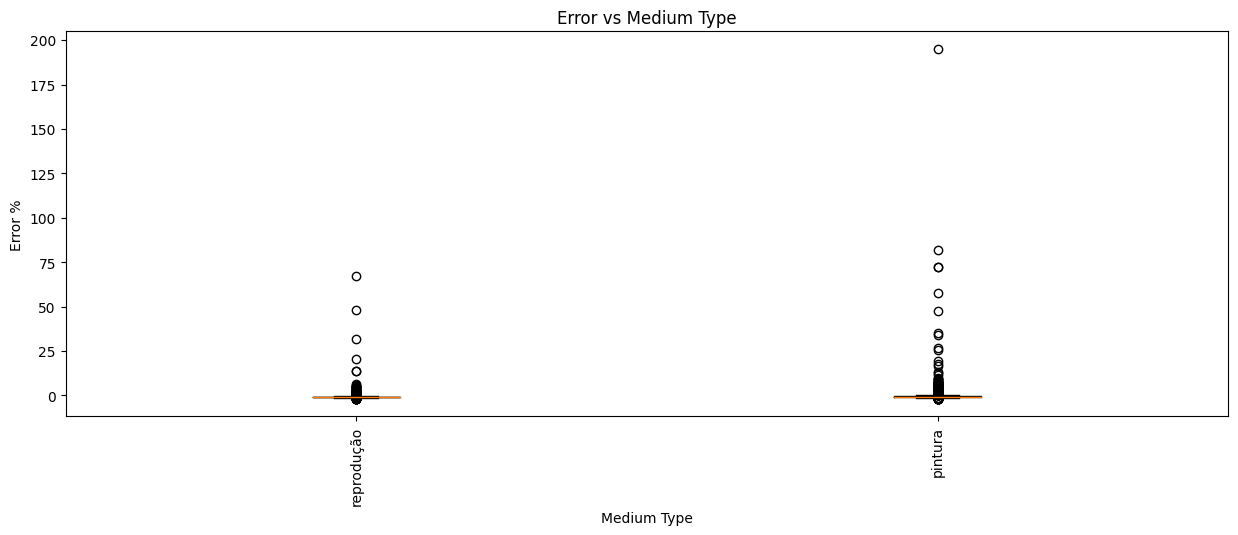

In [288]:
## ERROR ACROSS MEDIUM TYPES

medium_types = ['reprodução', 'pintura']# , 'desenho']

## Compare pct error across medium types
# boxplot: error vs medium type
plt.figure(figsize=(15, 5))
plt.title('Error vs Medium Type')
plt.xlabel('Medium Type')
plt.ylabel('Error %')
plt.xticks(rotation=90)
plt.boxplot([lots_copy[lots_copy['Medium_type_reprodução'] == 1]['Error %'],
             lots_copy[lots_copy['Medium_type_pintura'] == 1]['Error %']],
             labels=medium_types)
plt.show()

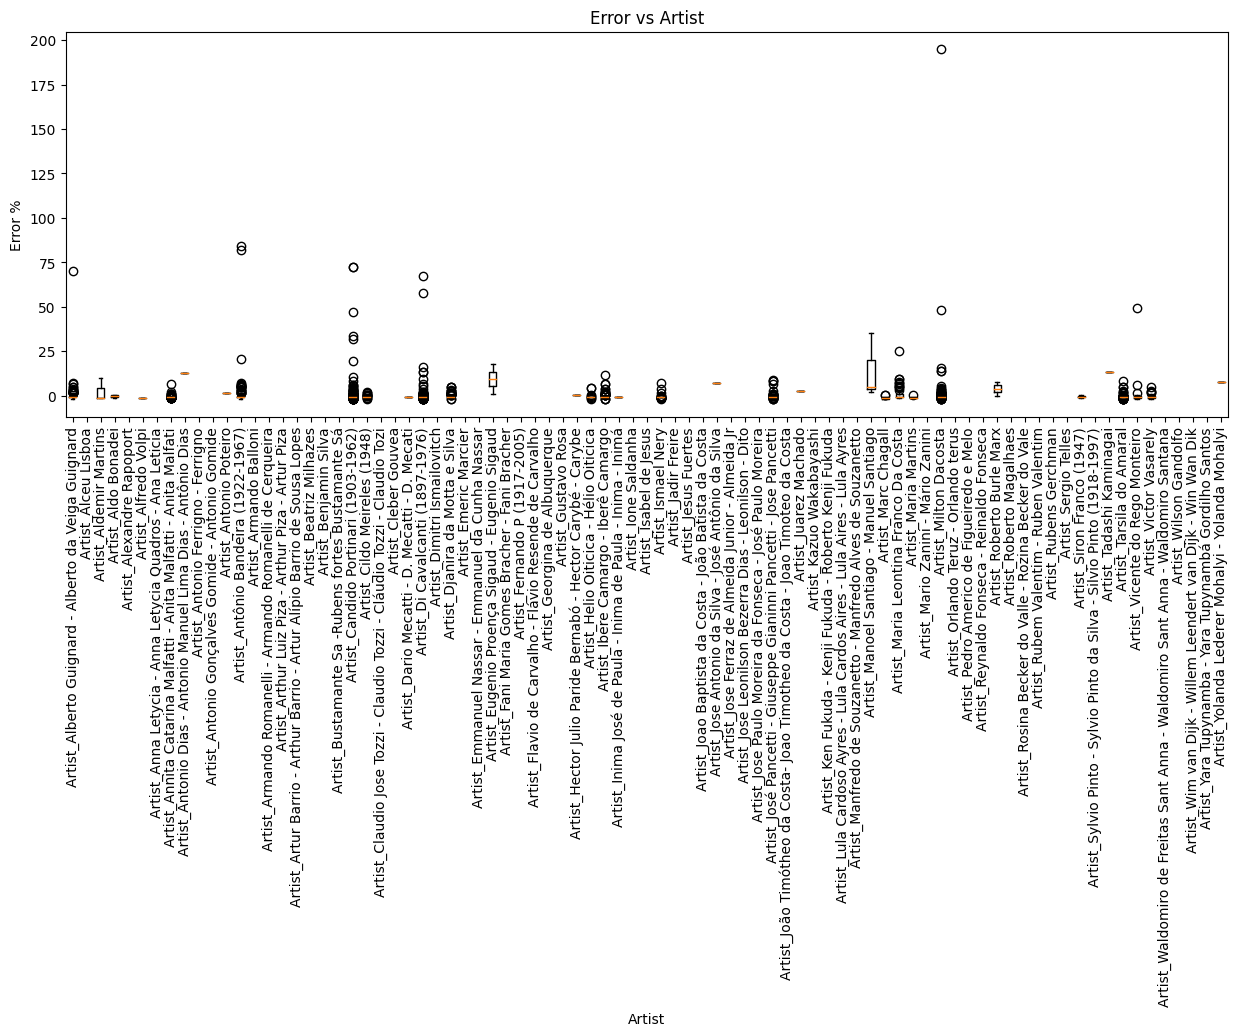

In [289]:
## COMPARE PCT ERROR ACROSS ARTISTS
artists = lots_copy.columns[:-10]

# boxplot: error vs artist
plt.figure(figsize=(15, 5))
plt.title('Error vs Artist')
plt.xlabel('Artist')
plt.ylabel('Error %')
plt.xticks(rotation=90)
plt.boxplot([lots_copy[lots_copy[artist] == 1]['Error %'] for artist in artists], labels=artists)
plt.show()

In [290]:
# show 10 biggest errors
lots_copy.sort_values('Error %', ascending=False).head(10)

,Artist_Alberto Guignard - Alberto da Veiga Guignard,Artist_Alceu Lisboa,Artist_Aldemir Martins,Artist_Aldo Bonadei,Artist_Alexandre Rapoport,Artist_Alfredo Volpi,Artist_Anna Letycia - Anna Letycia Quadros - Ana Leticia,Artist_Annita Catarina Malfatti - Anita Malfatti - Anita Malfati,Artist_Antonio Dias - Antonio Manuel Lima Dias - Antônio Dias,Artist_Antonio Ferrigno - Ferrigno,...,Artist_kinya Ikoma - K. Ikoma,Height (cm),Medium_type_pintura,Medium_type_reprodução,Width (cm),Year of sale,Predicted Price,Actual Price,Error,Error %
Year,,,,,,,,,,,,,,,,,,,,,
NaN,False,0,False,False,0,False,0,False,False,0,...,0,65.0,True,False,50.0,2013,7.880300e+04,400.0,7.840300e+04,195.007500
NaN,False,0,False,False,0,False,0,False,False,0,...,0,62.0,False,False,54.0,2017,3.444683e+05,4000.0,3.404683e+05,84.117083
NaN,False,0,False,False,0,False,0,False,False,0,...,0,82.0,True,False,96.0,2022,1.681100e+06,20000.0,1.661100e+06,82.055000
NaN,False,0,False,False,0,False,0,False,False,0,...,0,48.0,True,False,60.0,2020,2.451650e+05,3300.0,2.418650e+05,72.292424
NaN,False,0,False,False,0,False,0,False,False,0,...,0,48.0,True,False,60.0,2020,2.451650e+05,3300.0,2.418650e+05,72.292424
1956.0,True,0,False,False,0,False,0,False,False,0,...,0,57.0,False,False,48.0,2021,1.511270e+05,2100.0,1.490270e+05,69.965238
NaN,False,0,False,False,0,False,0,False,False,0,...,0,54.0,False,True,36.0,2023,2.417246e+04,350.0,2.382246e+04,67.064181
1969.0,False,0,False,False,0,False,0,False,False,0,...,0,15.0,True,False,26.0,2019,4.770450e+04,800.0,4.690450e+04,57.630625
NaN,False,0,False,False,0,False,0,False,False,0,...,0,16.0,False,False,22.0,2015,1.990620e+04,390.0,1.951620e+04,49.041538


In [291]:
## SAVE LOCALLY MODEL AND X_TEST

# save model to models folder
model = models['Gradient Boosting']
with open('./models/catalogo_gb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# save X_test as csv
X_test.to_csv('./models/catalogo_X_test.csv', index=False)